# <b>Malaria Detection</b>

## <b>Context</b>
Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes. The parasites enter the blood and begin damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other complications. The lethal parasites can stay alive for more than a year in a person’s body without showing any symptoms. Therefore, late treatment can cause complications and could even be fatal. Almost 50% of the world’s population is in danger from malaria. There were more than 229 million malaria cases and 400,000 malaria-related deaths reported over the world in 2019. Children under 5 years of age are the most vulnerable population group affected by malaria; in 2019 they accounted for 67% of all malaria deaths worldwide.
Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced professional to discriminate between healthy and infected red blood cells. It is a tedious, time-consuming process, and the diagnostic accuracy (which heavily depends on human expertise) can be adversely impacted by inter-observer variability.
An automated system can help with the early and accurate detection of malaria. Applications of automated classification techniques using Machine Learning (ML) and Artificial Intelligence (AI) have consistently shown higher accuracy than manual classification. It would therefore be highly beneficial to propose a method that performs malaria detection using Deep Learning Algorithms.

## <b>Objective</b>
Build an efficient computer vision model to detect malaria. The model should identify whether the image of a red blood cell is that of one infected with malaria or not, and classify the same as parasitized or uninfected, respectively.

## <b>Data Description </b>
This dataset consists of colored images of red blood cells that contain parasitized and uninfected instances, where:

**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


### <b> Mounting the Drive

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <b>Loading libraries</b>

In [1]:
# Data manipulation and preprocessing
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
from random import shuffle


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

# Modeling
import tensorflow as tf
import keras
from tensorflow.keras import backend
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import optimizers

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Changing the limit for the number of displayed columns and rows.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import datetime

2023-05-12 02:05:25.765895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### <b>Let's load the data</b>

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/Malaria Detection/cell_images.zip'

# Extracting the data
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

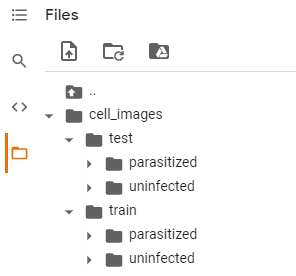

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do it for the training data first and then we will use the same code for the test data.

In [2]:
# Let's check the images dimensions

# train_dir = '/content/cell_images/train'
# test_dir = '/content/cell_images/test'

train_dir = 'cell_images/train'
test_dir = 'cell_images/test'

image_sizes = []

for dir in [train_dir,test_dir]:
    for folder_name in ['/parasitized/', '/uninfected/']:
        images_path = os.listdir(dir + folder_name)
    for i, image_name in enumerate(images_path):
        image = np.array(Image.open(dir + folder_name + image_name))
        image_sizes.append(image.shape)

In [ ]:
print('Min dimensions',
      np.array(list(zip(*image_sizes)))[0].min(),
      'x',
      np.array(list(zip(*image_sizes)))[1].min())

print('Max dimensions',
      np.array(list(zip(*image_sizes)))[0].max(),
      'x',
      np.array(list(zip(*image_sizes)))[1].max())

print('Mean dimensions',
      np.median(list(zip(*image_sizes))[0]),
      'x',
      np.median(list(zip(*image_sizes))[1]))

Min dimensions 40 x 49
Max dimensions 385 x 394
Mean dimensions 130.0 x 130.0


#### <b> Observations and insights:

- We can see that minimum dimension of an image inside our data is 40. 
- The max dimension is 394
- And the median dimensions are 130 x 130.

Let's use median dimensions to resize our images to make the computation optimal and preserve maximum of the information. 



In [3]:
# Size of image so that each image has the same size
SIZE = 130

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [4]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
    
        try:
    
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to the chosen size
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
            
                train_labels.append(1)
           
            else:
           
                train_labels.append(0)
        
        except Exception:
       
            pass       

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [5]:
# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [6]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            # Resizing each image to the chosen size
            image = image.resize((SIZE, SIZE))
            
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass       

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

### <b> Checking the shape of train and test images

In [ ]:
# Shape of images
print(train_images.shape)
print(test_images.shape)

(24958, 130, 130, 3)
(2600, 130, 130, 3)


### <b> Checking the shape of train and test labels

In [ ]:
# Shape of labels
print(train_labels.shape)
print(test_labels.shape)

(24958,)
(2600,)


In [ ]:
# Let's check the labels
print('Train labels\n',np.unique(train_labels,return_counts=True))
print('Test labels\n',np.unique(test_labels,return_counts=True))

Train labels
 (array([0, 1]), array([12376, 12582]))
Test labels
 (array([0, 1]), array([1300, 1300]))


#### <b> Observations and insights:

- After preprocessing we have 24958 train images (~ 90% of the data) and 2600 test images (~ 10% of the data) of size (130,130,3).
- In terms of labels both of the datasets are very balanced, which will help us in finding the optimal solution. 




### <b> Data normalization

In [7]:
train_images = train_images/255
test_images = test_images/255

### <b>Data Exploration</b>
Let's visualize the images from the train data

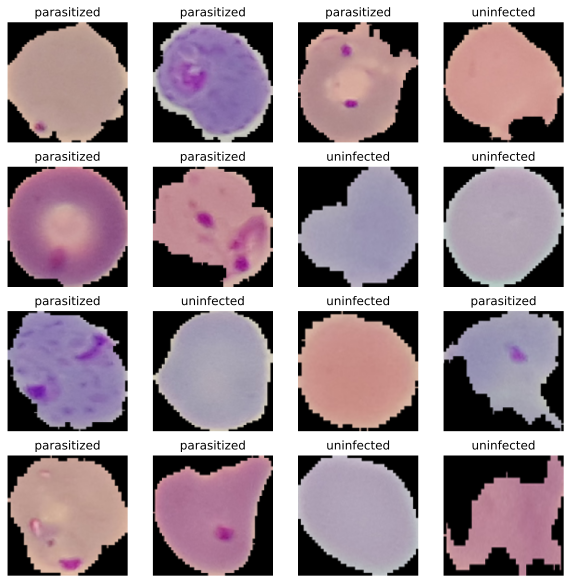

In [8]:
# Let's visualize some parasitized and uninfected images
np.random.seed(1)

plt.figure(1, figsize = (10 , 10))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1: 

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

#### <b>Observations and insights:

- We can see that that when we observe parasitized blood sample, there is some purple shape appears. 
- And in uninfected samples the color of a sample more or less even and regular.  

### <b>Converting RGB to HSV of Images using OpenCV

### <b> Converting the train data

In [9]:
train_images = train_images.astype('float32')

In [10]:
gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

    a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)
  
    gfx.append(a)

gfx = np.array(gfx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


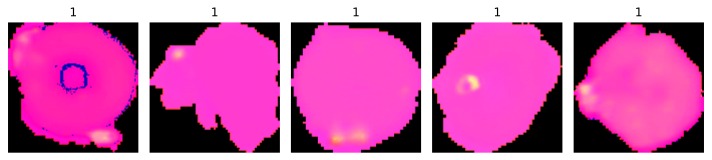

In [11]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 10))

for t, i in zip(range(5), viewimage):

    Title = train_labels[i]
    
    ax[t].set_title(Title)
    ax[t].imshow(gfx[i])
    ax[t].set_axis_off()
    fig.tight_layout()

### <b> Converting the test data

In [12]:
test_images = test_images.astype('float32')

In [13]:
gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

    a = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2HSV)
  
    gfx.append(a)

gfx = np.array(gfx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


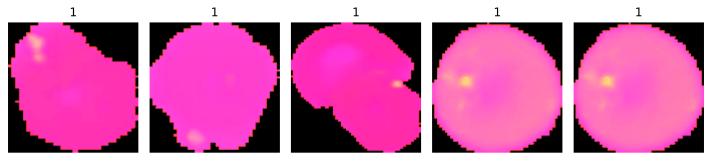

In [14]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 10))

for t, i in zip(range(5), viewimage):

    Title = test_labels[i]
    
    ax[t].set_title(Title)
    ax[t].imshow(gfx[i])
    ax[t].set_axis_off()
    fig.tight_layout()

#### <b>Observations and insights:
    
    - We see that infected area turned to yellowy-white. 

### <b> Processing Images using Gaussian Blurring

### <b> Gaussian Blurring on train data

In [15]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

    b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

    gbx.append(b)

gbx = np.array(gbx)

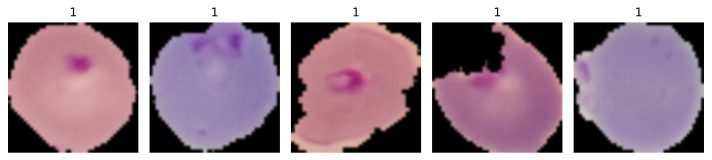

In [16]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 10))

for t, i in zip(range(5), viewimage):

    Title = train_labels[i]

    ax[t].set_title(Title)
    ax[t].imshow(gbx[i])
    ax[t].set_axis_off()
  
    fig.tight_layout()

### <b> Gaussian Blurring on test data

In [17]:
gbx = []

for i in np.arange(0, 100, 1):

    b = cv2.GaussianBlur(test_images[i], (5, 5), 0)

    gbx.append(b)

gbx = np.array(gbx)

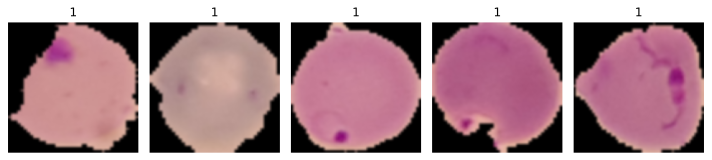

In [18]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize =(10, 10))

for t, i in zip(range(5), viewimage):

    Title = test_labels[i]

    ax[t].set_title(Title)
    ax[t].imshow(gbx[i])
    ax[t].set_axis_off()
  
    fig.tight_layout()

#### **Observations and insights:**

- Gaussian blurring seems to increase contrast. It may be benefical to use it later.

### <B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Test labels
test_labels = to_categorical(test_labels, 2)

### **Base Model**

Let's build a base model to start from. 

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### <b> Building the model

In [ ]:
# Creating sequential model
model = Sequential()

# Feature extraction

# CNN block 1
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# CNN block 2
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# CNN block 3
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


# Classification
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))

model.add(Dense(2, activation="softmax")) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 65, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 65, 65, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

### <b> Compiling the model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint('Model_base_{epoch:02d}-{val_accuracy:.4f}.hdf5', monitor='val_accuracy',save_weights_only=True, save_best_only=True)]

<b> Fit and train our Model

In [ ]:
# Fitting the model with min batch size 32
history = model.fit(train_images, train_labels, batch_size=32, callbacks=callbacks, validation_split=0.2, epochs=20, verbose=1)

Epoch 1/20
624/624 [==============================] - 172s 275ms/step - loss: 0.5582 - accuracy: 0.7140 - val_loss: 0.4284 - val_accuracy: 0.9786
Epoch 2/20
624/624 [==============================] - 157s 252ms/step - loss: 0.1968 - accuracy: 0.9355 - val_loss: 0.2348 - val_accuracy: 0.8994
Epoch 3/20
624/624 [==============================] - 153s 246ms/step - loss: 0.1398 - accuracy: 0.9505 - val_loss: 0.1666 - val_accuracy: 0.9551
Epoch 4/20
624/624 [==============================] - 151s 241ms/step - loss: 0.1161 - accuracy: 0.9596 - val_loss: 0.1064 - val_accuracy: 0.9679
Epoch 5/20
624/624 [==============================] - 153s 245ms/step - loss: 0.1146 - accuracy: 0.9651 - val_loss: 0.1070 - val_accuracy: 0.9776
Epoch 6/20
624/624 [==============================] - 158s 253ms/step - loss: 0.0951 - accuracy: 0.9704 - val_loss: 0.1486 - val_accuracy: 0.9802
Epoch 7/20
624/624 [==============================] - 159s 255ms/step - loss: 0.0889 - accuracy: 0.9731 - val_loss: 0.1060 -

### <b> Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 57ms/step - loss: 0.0971 - accuracy: 0.9792

 Test_Accuracy:- 0.9792307615280151


<b> Plotting the confusion matrix

82/82 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

           0     0.9763    0.9823    0.9793      1300
           1     0.9822    0.9762    0.9792      1300

    accuracy                         0.9792      2600
   macro avg     0.9792    0.9792    0.9792      2600
weighted avg     0.9792    0.9792    0.9792      2600



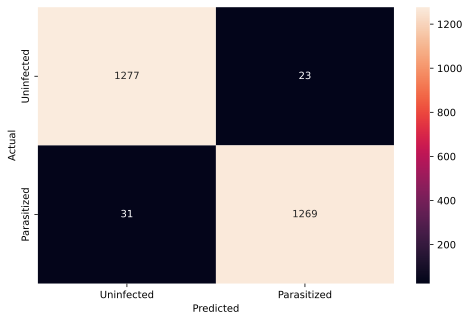

In [ ]:
pred = model.predict(test_images)

pred = np.argmax(pred, axis=1) 

y_true = np.argmax(test_labels, axis=1)

# Printing the classification report
print(classification_report(y_true, pred,digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(8, 5))

sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b>Plotting the train and validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

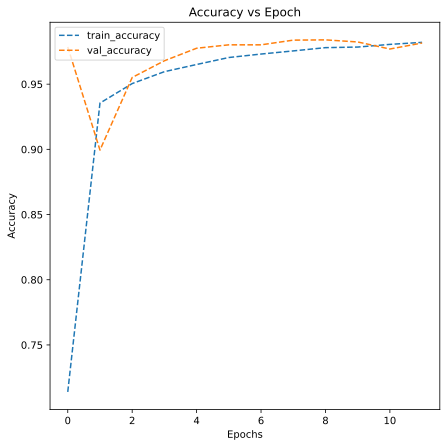

In [ ]:
plot_accuracy(history)

#### **Observations and insights:**

- Our base model is doing great and achieves spectacular result of 97.92% accuracy on the test dataset.
- The precision and recall are very balanced for both the classes.
- And the model is not overfitting. 

**Now let's try to build another model with few more add on layers and try to check if we can push the model performance further. And Let's build dataloaders to optimize computations.**

### <b> Dataloaders

In [ ]:
batch_size=32

In [ ]:
training_data = tf.keras.utils.image_dataset_from_directory(
                    train_dir,
                    label_mode = 'categorical',
                    validation_split=0.2,
                    subset='training',
                    seed=1,
                    batch_size=None,
                    image_size=(SIZE,SIZE),
                    interpolation='bicubic'
                    )

Found 24958 files belonging to 2 classes.
Using 19967 files for training.


In [ ]:
validation_data = tf.keras.utils.image_dataset_from_directory(
                    train_dir,
                    label_mode = 'categorical',
                    validation_split=0.2,
                    subset="validation",
                    seed=1,
                    batch_size=None,
                    image_size=(SIZE,SIZE),
                    interpolation='bicubic')

Found 24958 files belonging to 2 classes.
Using 4991 files for validation.


In [ ]:
testing_data = tf.keras.utils.image_dataset_from_directory(
                    test_dir,
                    label_mode = 'categorical',
                    seed=1,
                    batch_size=None,
                    image_size=(SIZE,SIZE),
                    interpolation='bicubic'
                    )

Found 2600 files belonging to 2 classes.


In [ ]:
print(training_data.class_names)
print(validation_data.class_names)
print(testing_data.class_names)

['parasitized', 'uninfected']
['parasitized', 'uninfected']
['parasitized', 'uninfected']


In [ ]:
# Let's configure the datasets for performance.
def configure_for_performance(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=ds.__len__().numpy())
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

training_data = configure_for_performance(training_data)
validation_data = configure_for_performance(validation_data)

### <b> Model 1
#### <b> Let's try to improve the performance of our model by adding new layers


In [ ]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### <b> Building the Model

In [ ]:
# Creating sequential model
model1 = Sequential()

# Feature extraction

# CNN block 1
model1.add(Conv2D(filters=256, kernel_size=2, padding="same", activation="relu", input_shape=(SIZE, SIZE, 3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.4))

# CNN block 2
model1.add(Conv2D(filters=128, kernel_size=2, padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.4))

# CNN block 3
model1.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.4))

# CNN block 4
model1.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.4))

# CNN block 5
model1.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.4))

# Classification

model1.add(Flatten())
model1.add(Dense(512, activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2, activation="softmax")) 

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 256)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 65, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 65, 65, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

### <b> Compiling the model

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3),
             ModelCheckpoint('Model_1_{epoch:02d}-{val_accuracy:.4f}.hdf5', monitor='val_accuracy',save_weights_only=True, save_best_only=True)]

<b>Fitting and Train the model

In [ ]:
history1 = model1.fit(training_data, validation_data=validation_data, callbacks=callbacks, epochs=20, verbose=1)

Epoch 1/20


2023-05-11 01:23:59.772811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 144 of 19968
2023-05-11 01:24:09.409158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 310 of 19968
2023-05-11 01:24:19.381251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 537 of 19968
2023-05-11 01:24:22.678447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


624/624 [==============================] - 6674s 11s/step - loss: 1.1556 - accuracy: 0.5079 - val_loss: 0.6929 - val_accuracy: 0.5107
Epoch 2/20
624/624 [==============================] - 4868s 8s/step - loss: 0.6128 - accuracy: 0.6401 - val_loss: 0.2590 - val_accuracy: 0.9483
Epoch 3/20
624/624 [==============================] - 4709s 8s/step - loss: 0.2006 - accuracy: 0.9402 - val_loss: 0.1419 - val_accuracy: 0.9563
Epoch 4/20
624/624 [==============================] - 4230s 7s/step - loss: 0.1379 - accuracy: 0.9573 - val_loss: 0.1492 - val_accuracy: 0.9495
Epoch 5/20
624/624 [==============================] - 1622s 3s/step - loss: 0.1268 - accuracy: 0.9630 - val_loss: 0.1149 - val_accuracy: 0.9609
Epoch 6/20
624/624 [==============================] - 1635s 3s/step - loss: 0.1162 - accuracy: 0.9674 - val_loss: 0.1478 - val_accuracy: 0.9569
Epoch 7/20
624/624 [==============================] - 1648s 3s/step - loss: 0.1104 - accuracy: 0.9686 - val_loss: 0.1113 - val_accuracy: 0.9611
Ep

In [ ]:
history1 = model1.fit(training_data, validation_data=validation_data, callbacks=callbacks, epochs=20, verbose=1)

Epoch 1/20
624/624 [==============================] - 1630s 3s/step - loss: 0.0931 - accuracy: 0.9719 - val_loss: 0.1143 - val_accuracy: 0.9621
Epoch 2/20
624/624 [==============================] - 2120s 3s/step - loss: 0.0961 - accuracy: 0.9705 - val_loss: 0.1178 - val_accuracy: 0.9635
Epoch 3/20
624/624 [==============================] - 2136s 3s/step - loss: 0.1002 - accuracy: 0.9709 - val_loss: 0.1172 - val_accuracy: 0.9683
Epoch 4/20
624/624 [==============================] - 2179s 3s/step - loss: 0.1009 - accuracy: 0.9704 - val_loss: 0.1373 - val_accuracy: 0.9617
Epoch 5/20
624/624 [==============================] - 2177s 3s/step - loss: 0.0951 - accuracy: 0.9726 - val_loss: 0.1645 - val_accuracy: 0.9513
Epoch 6/20
624/624 [==============================] - 2081s 3s/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.1402 - val_accuracy: 0.9595


#### **Observations and insights:**

-  Unfortunately the performance of this model is inferior to the initial one. 
- We will not use it. 

<b> Let's try transfer learning which is a go-to approach and usually gives the best results. 

# **Transfer Learning**

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

## **Model ConvNeXtBase**

Let's try ConvNeXtBase model which is modern and very potent. 



In [ ]:
conv_next_base_model = tf.keras.applications.convnext.ConvNeXtBase(
    model_name='convnext_base',
    include_top=False,
    input_shape=(SIZE,SIZE,3),
    include_preprocessing=True,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [ ]:
# Let's freeze the model
conv_next_base_model.trainable = False

In [ ]:
conv_next_base_model.summary()

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 130, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 130, 130, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 32, 32, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']         

In [ ]:
# Let's use data augmentation to enlarge the dataset in our disposal
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
# Let's get the feature batch shape
image_batch, label_batch = next(iter(training_data))
feature_batch = conv_next_base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1024)


In [ ]:
# Adding global average layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
# Adding prediction_layer
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
# Building the transfer learning model
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = data_augmentation(inputs)
x = conv_next_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_conv_next_base_transfer = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model_conv_next_base_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_conv_next_base_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 130, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 130, 130, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 4, 4, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                             

In [ ]:
# Checkpoint paths
ckpt_path=f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5'
csv_logger_path= f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/csv_log/log.csv'

# Tensorboard
%load_ext tensorboard
%rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Keras callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
csv_logger=CSVLogger(csv_logger_path,append=False)

# Model fitting
history = model_conv_next_base_transfer.fit(
          training_data,
          validation_data=validation_data,
          epochs=15, 
          callbacks=[es, mc, csv_logger, tensorboard_callback]
          )  



```
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
624/624 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8355
Epoch 1: val_accuracy improved from -inf to 0.85213, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5
624/624 [==============================] - 226s 329ms/step - loss: 0.4354 - accuracy: 0.8355 - val_loss: 0.3355 - val_accuracy: 0.8521
Epoch 2/15
624/624 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9186
Epoch 2: val_accuracy improved from 0.85213 to 0.86676, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5
624/624 [==============================] - 199s 319ms/step - loss: 0.2555 - accuracy: 0.9186 - val_loss: 0.3041 - val_accuracy: 0.8668
Epoch 3/15
624/624 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9357
Epoch 3: val_accuracy improved from 0.86676 to 0.87257, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5
624/624 [==============================] - 200s 320ms/step - loss: 0.2007 - accuracy: 0.9357 - val_loss: 0.2945 - val_accuracy: 0.8726
Epoch 4/15
624/624 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9405
Epoch 4: val_accuracy did not improve from 0.87257
624/624 [==============================] - 188s 301ms/step - loss: 0.1766 - accuracy: 0.9405 - val_loss: 0.3029 - val_accuracy: 0.8716
Epoch 5/15
624/624 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9464
Epoch 5: val_accuracy improved from 0.87257 to 0.88359, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5
624/624 [==============================] - 201s 322ms/step - loss: 0.1593 - accuracy: 0.9464 - val_loss: 0.2786 - val_accuracy: 0.8836
Epoch 6/15
624/624 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9487
Epoch 6: val_accuracy improved from 0.88359 to 0.88559, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer/best_model.h5
624/624 [==============================] - 211s 339ms/step - loss: 0.1490 - accuracy: 0.9487 - val_loss: 0.2802 - val_accuracy: 0.8856
Epoch 6: early stopping
```



### **Checking Test Accuracy**

In [ ]:
# Retrieve labels and images images from the test set
test_images, test_labels = zip(*testing_data)
test_images = np.array([img.numpy() for img in test_images])
test_labels = np.array([label.numpy() for label in test_labels])
y_true = np.argmax(test_labels, axis = 1)

In [ ]:
# Let's make predictions
pred = model_conv_next_base_transfer.predict(test_images)
pred = np.argmax(pred, axis = 1) 

82/82 [==============================] - 25s 267ms/step


              precision    recall  f1-score   support

           0     0.8031    0.9977    0.8899      1300
           1     0.9970    0.7554    0.8595      1300

    accuracy                         0.8765      2600
   macro avg     0.9000    0.8765    0.8747      2600
weighted avg     0.9000    0.8765    0.8747      2600



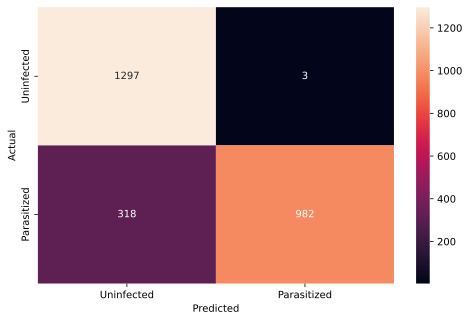

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            annot = True,
            fmt = '.0f',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- The accuracy is poor and the model is overfitting.
- Let's try fine tuning the model. 

### <b> Fine Tuning

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Let's unfreeze the model
conv_next_base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(conv_next_base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_next_base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  295


In [ ]:
# Let's use data augmentation to enlarge the dataset in our disposal
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
# Let's get the feature batch shape
image_batch, label_batch = next(iter(training_data))
feature_batch = conv_next_base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1024)


In [ ]:
# Adding global average layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
# Adding prediction_layer
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
# Building the transfer learning model
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = data_augmentation(inputs)
x = conv_next_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_conv_next_base_transfer_ft = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model_conv_next_base_transfer_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_conv_next_base_transfer_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 130, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 130, 130, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 4, 4, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                             

In [ ]:
# Checkpoint paths
ckpt_path=f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/best_model.h5'
csv_logger_path= f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/csv_log/log.csv'

# Tensorboard
%load_ext tensorboard
%rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Keras callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
csv_logger=CSVLogger(csv_logger_path,append=False)

# Model fitting
history = model_conv_next_base_transfer_ft.fit(
          training_data,
          validation_data=validation_data,
          epochs=15, 
          callbacks=[es, mc, csv_logger, tensorboard_callback]
          )  



```
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Reusing TensorBoard on port 6006 (pid 14802), started 0:34:47 ago. (Use '!kill 14802' to kill it.)
Epoch 1/15
624/624 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9728
Epoch 1: val_accuracy improved from -inf to 0.98097, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/best_model.h5
624/624 [==============================] - 364s 581ms/step - loss: 0.0778 - accuracy: 0.9728 - val_loss: 0.0557 - val_accuracy: 0.9810
Epoch 2/15
624/624 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9822
Epoch 2: val_accuracy did not improve from 0.98097
624/624 [==============================] - 329s 527ms/step - loss: 0.0521 - accuracy: 0.9822 - val_loss: 0.0697 - val_accuracy: 0.9778
Epoch 3/15
624/624 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9827
Epoch 3: val_accuracy did not improve from 0.98097
624/624 [==============================] - 329s 527ms/step - loss: 0.0470 - accuracy: 0.9827 - val_loss: 0.0548 - val_accuracy: 0.9808
Epoch 4/15
624/624 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9844
Epoch 4: val_accuracy did not improve from 0.98097
624/624 [==============================] - 318s 510ms/step - loss: 0.0383 - accuracy: 0.9844 - val_loss: 0.0640 - val_accuracy: 0.9802
Epoch 5/15
624/624 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9872
Epoch 5: val_accuracy improved from 0.98097 to 0.98177, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/best_model.h5
624/624 [==============================] - 338s 541ms/step - loss: 0.0345 - accuracy: 0.9872 - val_loss: 0.0591 - val_accuracy: 0.9818
Epoch 6/15
624/624 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9884
Epoch 6: val_accuracy did not improve from 0.98177
624/624 [==============================] - 330s 529ms/step - loss: 0.0309 - accuracy: 0.9884 - val_loss: 0.0735 - val_accuracy: 0.9792
Epoch 7/15
624/624 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9901
Epoch 7: val_accuracy improved from 0.98177 to 0.98197, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/best_model.h5
624/624 [==============================] - 333s 534ms/step - loss: 0.0269 - accuracy: 0.9901 - val_loss: 0.0610 - val_accuracy: 0.9820
Epoch 8/15
624/624 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9923
Epoch 8: val_accuracy improved from 0.98197 to 0.98237, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/Model_conv_next_base_transfer_fine_tuned/best_model.h5
624/624 [==============================] - 329s 527ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0644 - val_accuracy: 0.9824
Epoch 9/15
624/624 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9921
Epoch 9: val_accuracy did not improve from 0.98237
624/624 [==============================] - 318s 510ms/step - loss: 0.0220 - accuracy: 0.9921 - val_loss: 0.0629 - val_accuracy: 0.9812
Epoch 10/15
624/624 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9929
Epoch 10: val_accuracy did not improve from 0.98237
624/624 [==============================] - 318s 510ms/step - loss: 0.0181 - accuracy: 0.9929 - val_loss: 0.0720 - val_accuracy: 0.9794
Epoch 11/15
624/624 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9936
Epoch 11: val_accuracy did not improve from 0.98237
624/624 [==============================] - 328s 526ms/step - loss: 0.0177 - accuracy: 0.9936 - val_loss: 0.0669 - val_accuracy: 0.9816
Epoch 12/15
624/624 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9948
Epoch 12: val_accuracy did not improve from 0.98237
624/624 [==============================] - 329s 527ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0674 - val_accuracy: 0.9790
Epoch 12: early stopping
```



### **Checking Test Accuracy**

In [ ]:
# Retrieve labels and images images from the test set
test_images, test_labels = zip(*testing_data)
test_images = np.array([img.numpy() for img in test_images])
test_labels = np.array([label.numpy() for label in test_labels])
y_true = np.argmax(test_labels, axis = 1)

In [ ]:
# Let's make predictions
pred = model_conv_next_base_transfer_ft.predict(test_images)
pred = np.argmax(pred, axis = 1) 

82/82 [==============================] - 26s 270ms/step


              precision    recall  f1-score   support

           0     0.9869    0.9846    0.9858      1300
           1     0.9847    0.9869    0.9858      1300

    accuracy                         0.9858      2600
   macro avg     0.9858    0.9858    0.9858      2600
weighted avg     0.9858    0.9858    0.9858      2600



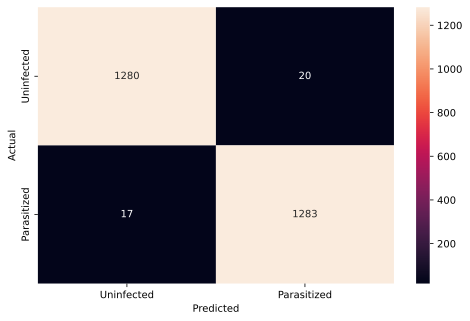

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            annot = True,
            fmt = '.0f',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- We managed to improve the model accuracy up-to 0.9858%.
- The precision and recall are very balanced.

Let's try one more architecture and see if we can improve the model perfomance even further.  

## <b> NasNetLarge

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
NasNetLarge = tf.keras.applications.NASNetLarge(
    input_shape=(SIZE,SIZE,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

343610240/343610240 [==============================] - 16s 0us/step


In [ ]:
# Let's freeze the model
NasNetLarge.trainable = False

NasNetLarge.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 130, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 64, 64, 96)   2592        ['input_1[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 64, 64, 96)   384         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 64, 64, 96)   0           ['stem_bn1[0][0]']          

In [ ]:
# Let's use data augmentation to enlarge the dataset in our disposal
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
# Let's get the feature batch shape
image_batch, label_batch = next(iter(training_data))
image_batch = tf.keras.applications.nasnet.preprocess_input(image_batch)
feature_batch = NasNetLarge(image_batch)
print(feature_batch.shape)

(32, 4, 4, 4032)


In [ ]:
# Adding global average layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 4032)


In [ ]:
# Adding prediction_layer
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
# Building the transfer learning model
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.nasnet.preprocess_input(x)
x = NasNetLarge(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
NasNetLarge = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
NasNetLarge.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
NasNetLarge.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 130, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 130, 130, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 130, 130, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 130, 130, 3)      0         
 a)                                                              
                                                                 
 NASNet (Functional)         (None, 4, 4, 4032)        84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0     

In [ ]:
# Checkpoint paths
ckpt_path=f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5'
csv_logger_path= f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/csv_log/log.csv'

# Tensorboard
%load_ext tensorboard
%rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Keras callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
csv_logger=CSVLogger(csv_logger_path,append=False)

# Model fitting
history = NasNetLarge.fit(
          training_data,
          validation_data=validation_data,
          epochs=15, 
          callbacks=[es, mc, csv_logger, tensorboard_callback]
          )  



```
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
624/624 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8265
Epoch 1: val_accuracy improved from -inf to 0.89040, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 184s 260ms/step - loss: 0.4352 - accuracy: 0.8265 - val_loss: 0.3158 - val_accuracy: 0.8904
Epoch 2/15
624/624 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8869
Epoch 2: val_accuracy improved from 0.89040 to 0.90884, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 147s 235ms/step - loss: 0.3142 - accuracy: 0.8869 - val_loss: 0.2629 - val_accuracy: 0.9088
Epoch 3/15
624/624 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9020
Epoch 3: val_accuracy improved from 0.90884 to 0.91485, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 150s 240ms/step - loss: 0.2755 - accuracy: 0.9020 - val_loss: 0.2444 - val_accuracy: 0.9148
Epoch 4/15
624/624 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9053
Epoch 4: val_accuracy improved from 0.91485 to 0.92306, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 145s 232ms/step - loss: 0.2606 - accuracy: 0.9053 - val_loss: 0.2246 - val_accuracy: 0.9231
Epoch 5/15
624/624 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9141
Epoch 5: val_accuracy improved from 0.92306 to 0.92647, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 146s 233ms/step - loss: 0.2447 - accuracy: 0.9141 - val_loss: 0.2161 - val_accuracy: 0.9265
Epoch 6/15
624/624 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9178
Epoch 6: val_accuracy improved from 0.92647 to 0.93007, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 169s 271ms/step - loss: 0.2342 - accuracy: 0.9178 - val_loss: 0.2063 - val_accuracy: 0.9301
Epoch 7/15
624/624 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9201
Epoch 7: val_accuracy improved from 0.93007 to 0.93168, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 146s 233ms/step - loss: 0.2257 - accuracy: 0.9201 - val_loss: 0.2007 - val_accuracy: 0.9317
Epoch 8/15
624/624 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9207
Epoch 8: val_accuracy improved from 0.93168 to 0.93368, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 164s 262ms/step - loss: 0.2256 - accuracy: 0.9207 - val_loss: 0.1960 - val_accuracy: 0.9337
Epoch 9/15
624/624 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9213
Epoch 9: val_accuracy improved from 0.93368 to 0.93388, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 145s 232ms/step - loss: 0.2182 - accuracy: 0.9213 - val_loss: 0.1929 - val_accuracy: 0.9339
Epoch 10/15
624/624 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9195
Epoch 10: val_accuracy improved from 0.93388 to 0.93709, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 164s 263ms/step - loss: 0.2209 - accuracy: 0.9195 - val_loss: 0.1869 - val_accuracy: 0.9371
Epoch 11/15
624/624 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9256
Epoch 11: val_accuracy improved from 0.93709 to 0.93789, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge/best_model.h5
624/624 [==============================] - 145s 233ms/step - loss: 0.2140 - accuracy: 0.9256 - val_loss: 0.1843 - val_accuracy: 0.9379
Epoch 11: early stopping
```



### **Checking Test Accuracy**

In [ ]:
# Retrieve labels and images images from the test set
test_images, test_labels = zip(*testing_data)
test_images = np.array([img.numpy() for img in test_images])
test_labels = np.array([label.numpy() for label in test_labels])
y_true = np.argmax(test_labels, axis = 1)

In [ ]:
# Let's make predictions
pred = NasNetLarge.predict(test_images)
pred = np.argmax(pred, axis = 1) 

82/82 [==============================] - 20s 147ms/step


              precision    recall  f1-score   support

           0     0.9377    0.9500    0.9438      1300
           1     0.9493    0.9369    0.9431      1300

    accuracy                         0.9435      2600
   macro avg     0.9435    0.9435    0.9435      2600
weighted avg     0.9435    0.9435    0.9435      2600



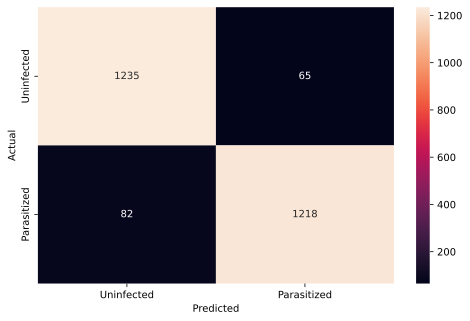

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            annot = True,
            fmt = '.0f',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- NasNetLarge model is doing much better than untuned ConvNeXTBase did.
- But with untuned we still achieve inferior accuracy to what was the best case so far which is tunet ConvNeXTBase 
- Let's try to tune NasNetLarge

### <b> Fine Tuning

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
NasNetLarge = tf.keras.applications.NASNetLarge(
    input_shape=(SIZE,SIZE,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
# Let's unfreeze the model
NasNetLarge.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(NasNetLarge.layers))

Number of layers in the base model:  1039


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in NasNetLarge.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Let's use data augmentation to enlarge the dataset in our disposal
data_augmentation = tf.keras.Sequential(
  [tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(SIZE, SIZE, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
# Let's get the feature batch shape
image_batch, label_batch = next(iter(training_data))
image_batch = tf.keras.applications.nasnet.preprocess_input(image_batch)
feature_batch = NasNetLarge(image_batch)
print(feature_batch.shape)

(32, 4, 4, 4032)


In [ ]:
# Adding global average layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 4032)


In [ ]:
# Adding prediction_layer
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
# Building the transfer learning model
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.nasnet.preprocess_input(x)
x = NasNetLarge(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
NasNetLarge_ft = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
NasNetLarge_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
NasNetLarge_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 130, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 130, 130, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 130, 130, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 130, 130, 3)      0         
 a)                                                              
                                                                 
 NASNet (Functional)         (None, 4, 4, 4032)        84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0     

In [ ]:
# Checkpoint paths
ckpt_path=f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5'
csv_logger_path= f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/csv_log/log.csv'

# Tensorboard
%load_ext tensorboard
%rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Keras callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
csv_logger=CSVLogger(csv_logger_path,append=False)

# Model fitting
history = NasNetLarge_ft.fit(
          training_data,
          validation_data=validation_data,
          epochs=15, 
          callbacks=[es, mc, csv_logger, tensorboard_callback]
          )  


```
Epoch 1/15
624/624 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9722
Epoch 1: val_accuracy improved from -inf to 0.98237, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5
624/624 [==============================] - 655s 711ms/step - loss: 0.0793 - accuracy: 0.9722 - val_loss: 0.0572 - val_accuracy: 0.9824
Epoch 2/15
624/624 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9808
Epoch 2: val_accuracy improved from 0.98237 to 0.98277, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5
624/624 [==============================] - 429s 686ms/step - loss: 0.0546 - accuracy: 0.9808 - val_loss: 0.0506 - val_accuracy: 0.9828
Epoch 3/15
624/624 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9814
Epoch 3: val_accuracy did not improve from 0.98277
624/624 [==============================] - 421s 674ms/step - loss: 0.0527 - accuracy: 0.9814 - val_loss: 0.0474 - val_accuracy: 0.9816
Epoch 4/15
624/624 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9818
Epoch 4: val_accuracy improved from 0.98277 to 0.98417, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5
624/624 [==============================] - 434s 695ms/step - loss: 0.0484 - accuracy: 0.9818 - val_loss: 0.0442 - val_accuracy: 0.9842
Epoch 5/15
624/624 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9832
Epoch 5: val_accuracy did not improve from 0.98417
624/624 [==============================] - 419s 672ms/step - loss: 0.0467 - accuracy: 0.9832 - val_loss: 0.0449 - val_accuracy: 0.9826
Epoch 6/15
624/624 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9841
Epoch 6: val_accuracy did not improve from 0.98417
624/624 [==============================] - 420s 673ms/step - loss: 0.0450 - accuracy: 0.9841 - val_loss: 0.0449 - val_accuracy: 0.9838
Epoch 7/15
624/624 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9826
Epoch 7: val_accuracy did not improve from 0.98417
624/624 [==============================] - 420s 672ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.0481 - val_accuracy: 0.9834
Epoch 8/15
624/624 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9837
Epoch 8: val_accuracy did not improve from 0.98417
624/624 [==============================] - 420s 673ms/step - loss: 0.0433 - accuracy: 0.9837 - val_loss: 0.0473 - val_accuracy: 0.9836
Epoch 9/15
624/624 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9849
Epoch 9: val_accuracy did not improve from 0.98417
624/624 [==============================] - 419s 672ms/step - loss: 0.0426 - accuracy: 0.9849 - val_loss: 0.0478 - val_accuracy: 0.9832
Epoch 10/15
624/624 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9848
Epoch 10: val_accuracy did not improve from 0.98417
624/624 [==============================] - 439s 703ms/step - loss: 0.0418 - accuracy: 0.9848 - val_loss: 0.0510 - val_accuracy: 0.9836
Epoch 11/15
624/624 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9841
Epoch 11: val_accuracy did not improve from 0.98417
624/624 [==============================] - 439s 704ms/step - loss: 0.0412 - accuracy: 0.9841 - val_loss: 0.0647 - val_accuracy: 0.9810
Epoch 12/15
624/624 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9845
Epoch 12: val_accuracy did not improve from 0.98417
624/624 [==============================] - 420s 673ms/step - loss: 0.0413 - accuracy: 0.9845 - val_loss: 0.0545 - val_accuracy: 0.9838
Epoch 13/15
624/624 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9862
Epoch 13: val_accuracy did not improve from 0.98417
```



<b> The session crushed. Let's continue from where we stopped. 

In [ ]:
weights_path='/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5'
NasNetLarge_ft.load_weights(weights_path)

In [ ]:
# Checkpoint paths
ckpt_path=f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5'
csv_logger_path= f'/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/csv_log/log.csv'

# Tensorboard
%load_ext tensorboard
%rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Keras callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
csv_logger=CSVLogger(csv_logger_path,append=False)

# Model fitting
history = NasNetLarge_ft.fit(
          training_data,
          validation_data=validation_data,
          epochs=10, 
          callbacks=[es, mc, csv_logger, tensorboard_callback]
          )


```
Reusing TensorBoard on port 6006 (pid 16852), started 1:46:43 ago. (Use '!kill 16852' to kill it.)
Epoch 1/10
624/624 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.98317, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5
624/624 [==============================] - 640s 703ms/step - loss: 0.0506 - accuracy: 0.9823 - val_loss: 0.0500 - val_accuracy: 0.9832
Epoch 2/10
624/624 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9811
Epoch 2: val_accuracy improved from 0.98317 to 0.98437, saving model to /content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5
624/624 [==============================] - 421s 674ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0456 - val_accuracy: 0.9844
Epoch 3/10
624/624 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9831
Epoch 3: val_accuracy did not improve from 0.98437
624/624 [==============================] - 437s 700ms/step - loss: 0.0445 - accuracy: 0.9831 - val_loss: 0.0529 - val_accuracy: 0.9832
Epoch 4/10
624/624 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9835
Epoch 4: val_accuracy did not improve from 0.98437
624/624 [==============================] - 416s 666ms/step - loss: 0.0468 - accuracy: 0.9835 - val_loss: 0.0445 - val_accuracy: 0.9830
Epoch 5/10
624/624 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9849
Epoch 5: val_accuracy did not improve from 0.98437
624/624 [==============================] - 414s 663ms/step - loss: 0.0405 - accuracy: 0.9849 - val_loss: 0.0585 - val_accuracy: 0.9812
Epoch 6/10
624/624 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9852
Epoch 6: val_accuracy did not improve from 0.98437
624/624 [==============================] - 417s 669ms/step - loss: 0.0401 - accuracy: 0.9852 - val_loss: 0.0487 - val_accuracy: 0.9834
Epoch 7/10
539/624 [========================>.....] - ETA: 50s - loss: 0.0373 - accuracy: 0.9852
```



### **Plotting the Training and Validation Accuracies**

### **Checking Test Accuracy**

In [ ]:
weights_path='/content/drive/MyDrive/Colab Notebooks/Malaria Detection/Models/NasNetLarge_fine_tuned/best_model.h5'
NasNetLarge_ft.load_weights(weights_path)

In [ ]:
# Retrieve labels and images images from the test set
test_images, test_labels = zip(*testing_data)
test_images = np.array([img.numpy() for img in test_images])
test_labels = np.array([label.numpy() for label in test_labels])
y_true = np.argmax(test_labels, axis = 1)

In [ ]:
# Let's make predictions
pred = NasNetLarge_ft.predict(test_images)
pred = np.argmax(pred, axis = 1) 

82/82 [==============================] - 313s 4s/step


              precision    recall  f1-score   support

           0     0.9832    0.9931    0.9881      1300
           1     0.9930    0.9831    0.9880      1300

    accuracy                         0.9881      2600
   macro avg     0.9881    0.9881    0.9881      2600
weighted avg     0.9881    0.9881    0.9881      2600



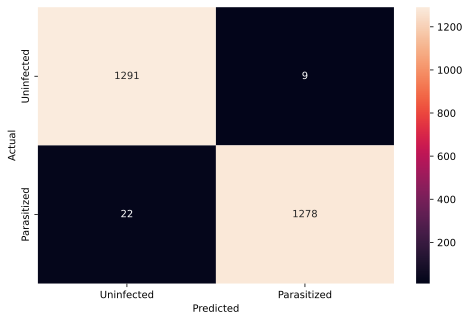

In [ ]:
# Printing the classification report
print(classification_report(y_true, pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            annot = True,
            fmt = '.0f',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- The tuned NasNetLarge model achieved the best performance of all the models we tried. 
- The precision and recall are very balanced among and inside the classes. 

We will stop on this model as it shows spectacular performance of 98.81% accuracy. 


#### **Proposal for the final solution design**:
-  We propose to use tuned NasNetLarge model as it achieved spectacular performance of 98.81% and outperforms proffessional laborants who do tests on malaria (~ 80%, source: https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-9-192#:~:text=The%20positive%20predictive%20value%20(PPV)%20for%20malaria%20infection%20in%20patients,dry%20and%20rainy%20season%2C%20respectively.)

- As recall seems much more important not to miss the patient with the decease, it might be tuned by setting threshold while inferencing. This can be done to improve the models recall, but it will negatively affect the precision. 
